## **Setting Things Up**

**1 If you haven't already, please hit :**

`File > Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


**2 In order to use a GPU with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then set the hardware accelerator dropdown to GPU. This can significantly speed up the training process.**

**3 In order to have enough memory with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then select High-RAM in the Runtime shape dropdown.**

To facilitate your initial progress, we have included a ready-to-use code on Google Colab for this problem. It allows you to get started immediately without the need to install any software libraries. Additionally, if you prefer not to use Google Colab and prefer setting up your own programming environment or employing alternative methods, the provided files and code will still be valuable.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 21 08:46:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# -*-coding:utf8 -*-
import tensorflow as tf
# print("TensorFlow version:", tf.__version__)

import os

import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.python import keras
from keras.layers import Dense, Flatten, Conv2D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception
# from keras.applications.resnet_v2 import ResNet152V2
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.densenet import DenseNet201
# from keras.applications.efficientnet import EfficientNetB7
# from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras import Model, Input, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction/new_interior_images_with_folder
!unzip "new_interior_images_with_folder.zip"

流式输出内容被截断，只能显示最后 5000 行内容。
   creating: 2007 Mercedes-Benz M-Class/
  inflating: 2007 Mercedes-Benz M-Class/2007 Mercedes-Benz M-Class.jpg  
   creating: 2007 Mercury Milan/
  inflating: 2007 Mercury Milan/2007 Mercury Milan.jpg  
   creating: 2007 Mercury Montego/
  inflating: 2007 Mercury Montego/2007 Mercury Montego.jpg  
   creating: 2007 Mercury Mountaineer/
  inflating: 2007 Mercury Mountaineer/2007 Mercury Mountaineer.jpg  
   creating: 2007 MINI Cooper/
  inflating: 2007 MINI Cooper/2007 MINI Cooper.jpg  
   creating: 2007 Mitsubishi Endeavor/
  inflating: 2007 Mitsubishi Endeavor/2007 Mitsubishi Endeavor.jpg  
   creating: 2007 Nissan Maxima/
  inflating: 2007 Nissan Maxima/2007 Nissan Maxima.jpg  
   creating: 2007 Nissan Quest/
  inflating: 2007 Nissan Quest/2007 Nissan Quest.jpg  
   creating: 2007 Nissan Sentra/
  inflating: 2007 Nissan Sentra/2007 Nissan Sentra.jpg  
   creating: 2007 Nissan Versa/
  inflating: 2007 Nissan Versa/2007 Nissan Versa.jpg  
   creating: 2007 P

In [ ]:
# change to your personal project address

%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction

/content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction


## **1 Data Processing**

In [ ]:
var = "interior score"
# var = "total score"
# var = "safety score"
# var = "performance score"
# var = "critics score"

In [ ]:
# 1 first we need to get the total score information from the csv file
# read info_data
file_name = "parametric data 2571 normalize " + var + ".csv"
info_data = pd.read_csv(file_name)
# get numpy matrix which only contains data (do not contain the title)
info_data = np.array(info_data)
print(info_data.shape)  # (2579, 303)
print(len(info_data))
print(info_data.shape[1])

(2571, 310)
2571
310


In [ ]:
# Input Parametric Data (2571x303)
# column 0: origin index
# column 1: model name
# column 2-303: parametric feature
# column 304: total score
# column 305: critics score
# column 306: performance score
# column 307: interior score
# column 308: safety score
# column 309: data split index => 1: train data; 2: validation data; 3:test data

In [ ]:
# train data shuffle index
num1 = 2055
idx1 = tf.range(num1)
idx1 = tf.random.shuffle(idx1)
# print(idx1)
# print(idx1[0])
with tf.compat.v1.Session():
    index1 = idx1.numpy()
# print(index1.shape)
# print(index1[0])

# validation data shuffle index
num2 = 258
idx2 = tf.range(num2)
idx2 = tf.random.shuffle(idx2)
# print(idx2)
# print(idx2[0])
with tf.compat.v1.Session():
    index2 = idx2.numpy()
# print(index2.shape)
# print(index2[0])

# test data shuffle index
num3 = 258
idx3 = tf.range(num3)
idx3 = tf.random.shuffle(idx3)
# print(idx3)
# print(idx3[0])
with tf.compat.v1.Session():
    index3 = idx3.numpy()
# print(index3.shape)
# print(index3[0])

In [ ]:
# assign the parametric data
# To predict the total score, you will need to assign the y variable using the values in column 304 of the parametric data.
# column 304: total score
# column 305: critics score
# column 306: performance score
# column 307: interior score
# column 308: safety score

y_train_tab = np.zeros((num1, 1))
for i in range(num1):
    y_train_tab[i] = np.array(info_data[index1[i], 304], dtype=float)
y_train_tab = tf.convert_to_tensor(y_train_tab)
y_train = y_train_tab
# print(y_train_tab)

y_validation_tab = np.zeros((num2, 1))
for i in range(num2):
    y_validation_tab[i] = np.array(info_data[index2[i] + num1, 304], dtype=float)
y_validation_tab = tf.convert_to_tensor(y_validation_tab)
y_validation = y_validation_tab
# print(y_validation_tab)

y_test_tab = np.zeros((num3, 1))
for i in range(num3):
    y_test_tab[i] = np.array(info_data[index3[i] + num1 + num2, 304], dtype=float)
y_test_tab = tf.convert_to_tensor(y_test_tab)
y_test = y_test_tab
# print(y_test_tab)

**Please take note of the image dimensions. For interior images, each image has dimensions of 300x448x3, whereas for exterior images, each image has dimensions of 290x448x3.**

In [ ]:
# assign the image data
image = np.zeros((300, 448, 3))
x_train = np.zeros((num1, 300, 448, 3))  # 2055x224x224x3
x_validation = np.zeros((num2, 300, 448, 3))  # 258x224x224x3
x_test = np.zeros((num3, 300, 448, 3))  # 258x224x224x3
# image = image_data[0]

# train data
for i in range(num1):
    folder_path = r'new_interior_images_with_folder/' + info_data[index1[i]][1]
    dirs = os.listdir(folder_path)
    print(i)
    if len(dirs) > 0:
        # only one total picture
        dirpath = folder_path + '/' + dirs[0]  # get the angular front view of the car
        img = Image.open(dirpath)
        img_plt = np.array(img)
        x_train[i, :, :, :] = img_plt / 255.0


# validation data
for i in range(num2):
    folder_path = r'new_interior_images_with_folder/' + info_data[index2[i]+num1][1]
    dirs = os.listdir(folder_path)
    print(i)
    if len(dirs) > 0:
        # only one total picture
        dirpath = folder_path + '/' + dirs[0]  # get the angular front view of the car
        img = Image.open(dirpath)
        img_plt = np.array(img)
        x_validation[i, :, :, :] = img_plt / 255.0


# test data
for i in range(num3):
    folder_path = r'new_interior_images_with_folder/' + info_data[index3[i]+num1+num2][1]
    dirs = os.listdir(folder_path)
    print(i)
    if len(dirs) > 0:
        # only one total picture
        dirpath = folder_path + '/' + dirs[0]  # get the angular front view of the car
        img = Image.open(dirpath)
        img_plt = np.array(img)
        x_test[i, :, :, :] = img_plt / 255.0


x_train = tf.convert_to_tensor(x_train)
x_validation = tf.convert_to_tensor(x_validation)
x_test = tf.convert_to_tensor(x_test)
# print(x_test.shape)
# print(x_test[0].shape)
# print(x_test)

# print(y_train)
# print(y_validation)
# print(y_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(2055, 300, 448, 3)
(2055, 1)


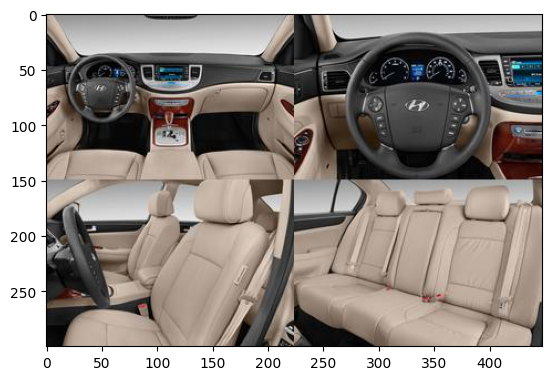

(258, 300, 448, 3)


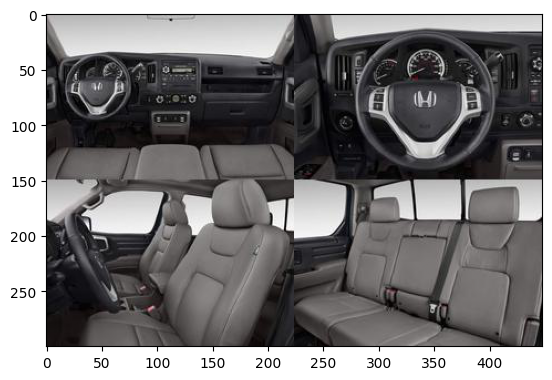

(258, 300, 448, 3)
(258, 1)


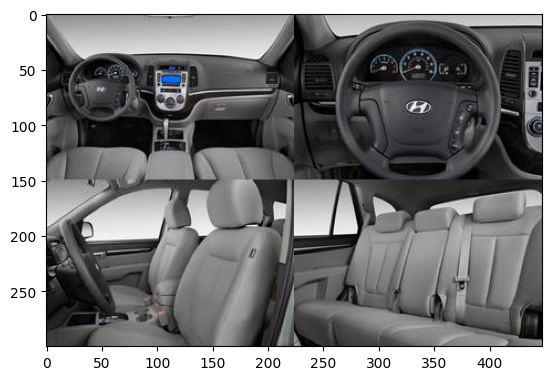

In [ ]:
print(x_train.shape)
print(y_train.shape)
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()
# plt.imshow(x_train[2403], cmap=plt.cm.binary)
# plt.show()

print(x_validation.shape)
plt.imshow(x_validation[0], cmap=plt.cm.binary)
plt.show()
# plt.imshow(x_validation[802], cmap=plt.cm.binary)
# plt.show()

print(x_test.shape)
print(y_test.shape)
plt.imshow(x_test[0], cmap=plt.cm.binary)
plt.show()
# plt.imshow(x_test[764], cmap=plt.cm.binary)
# plt.show()

## **2 Construct CNN Model**

In [ ]:
# 4 construct CNN model
# adam_optimizer = Adam(learning_rate=0.00023)
adam_optimizer = Adam(learning_rate=0.0001)
rms_prop_optimizer = RMSprop(learning_rate=0.001)
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)

In [ ]:
fc = 32

input_tensor = Input(shape=image.shape, name='Img_input')
base_model = VGG16(include_top=False, weights='imagenet', input_shape=image.shape, input_tensor=None)

x = base_model(input_tensor)

for layer in base_model.layers:
    layer.trainable = True

x = layers.Reshape((x.shape[1]*x.shape[2], x.shape[3]), name='Img_reshape')(x)
key = layers.Dense(fc, activation='relu', name='Img_key')(x)
query = layers.Dense(fc, activation='relu', name='Img_query')(x)
# query = key
value = layers.Dense(fc, activation='relu', name='Img_value')(x)

score = tf.matmul(query, tf.transpose(key, perm=[0, 2, 1], name='Img_k_transpose'), name='Img_q_k_matual') / np.sqrt(fc)
attn = tf.nn.softmax(score, -1, name='Img_attn_softmax')
context = tf.matmul(attn, value, name='Img_a_v_matmul')

# Flatten the output layer to 1 dimension
context = layers.Flatten(name='Img_flatten_after_self_attention')(context)

# sas = after self-attention
context = layers.Dense(1024, activation='relu', name='Img_asa_dense1')(context)
context = layers.Dropout(0.2, name='Img_asa_dropout1')(context)

context = layers.Dense(100, activation='relu', name='Img_asa_dense2')(context)


# Add a final relu layer for regression output
out1x = layers.Dense(1, name='Img_out1x')(context)

model = Model(inputs=input_tensor, outputs=out1x, name='Interior_Image_Model')

model.compile(
    optimizer=adam_optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse', 'mae']
)

model.summary()


Model: "Interior_Image_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Img_input (InputLayer)         [(None, 300, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 9, 14, 512)   14714688    ['Img_input[0][0]']              
                                                                                                  
 Img_reshape (Reshape)          (None, 126, 512)     0           ['vgg16[0][0]']                  
                                                                                                  
 Img_key (Dense)                (None, 126, 100)     51300       ['Img_reshape[

In [ ]:
def scheduler(epoch, lr):
    min_lr = 0.0000001
    if epoch < 5:
        return lr
    else:
        if lr < min_lr:
            lr = min_lr
            return lr
        else:
          # lr = 0.00003
          return lr * tf.math.exp(-0.01)
          # return lr


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_loss", restore_best_weights=True, verbose=1)
# EPOCHS = 200
EPOCHS = 300
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(x_validation, y_validation),
                    shuffle=True, verbose=2, callbacks=[early_stop, reduce_lr])
print(history)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/300
65/65 - 12s - loss: 0.5516 - rmse: 0.7427 - mse: 0.5516 - mae: 0.2681 - val_loss: 0.0186 - val_rmse: 0.1363 - val_mse: 0.0186 - val_mae: 0.1055 - lr: 1.0000e-04 - 12s/epoch - 187ms/step

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/300
65/65 - 10s - loss: 0.0221 - rmse: 0.1487 - mse: 0.0221 - mae: 0.1176 - val_loss: 0.0160 - val_rmse: 0.1266 - val_mse: 0.0160 - val_mae: 0.1003 - lr: 1.0000e-04 - 10s/epoch - 155ms/step

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/300
65/65 - 10s - loss: 0.0188 - rmse: 0.1370 - mse: 0.0188 - mae: 0.1091 - val_loss: 0.0158 - val_rmse: 0.1258 - val_mse: 0.0158 - val_mae: 0.0980 - lr: 1.0000e-04 - 10s/epoch - 155ms/step

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/300
65/65 - 10s - loss: 0.0185 - rmse: 0.1362 - mse: 0.0185 - mae: 0.1071 - va

## **3 Model Evaluation and Results**

In [ ]:
test_loss, test_rmse, test_mse, test_mae = model.evaluate(x_test, y_test, verbose=2)
validation_loss, validation_rmse, validation_mse, validation_mae = model.evaluate(x_validation, y_validation, verbose=2)
train_loss, train_rmse, train_mse, train_mae = model.evaluate(x_train, y_train, verbose=2)



9/9 - 1s - loss: 0.0097 - rmse: 0.0986 - mse: 0.0097 - mae: 0.0745 - 610ms/epoch - 68ms/step
9/9 - 1s - loss: 0.0077 - rmse: 0.0876 - mse: 0.0077 - mae: 0.0679 - 599ms/epoch - 67ms/step
65/65 - 4s - loss: 0.0019 - rmse: 0.0433 - mse: 0.0019 - mae: 0.0323 - 4s/epoch - 68ms/step


In [ ]:
result = model.predict(x_test)
# print(result)
# print(result[0])

9/9 [==============================] - 1s 61ms/step


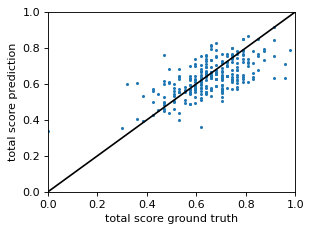

In [ ]:
figure(figsize=(4, 3), dpi=80)
plt.scatter(y_test, result, s=3)
# plt.legend()
x = [0, 1]
y = [0, 1]
plt.plot(x, y, color="black")
plt.xlabel(var + ' ground truth')
plt.ylabel(var + ' prediction')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# plot_history(history)

In [ ]:
from math import nan
test = np.array(y_test).T
# print(test)
predict = np.array(result).T

correlation_matrix = np.corrcoef(test, predict)
print(correlation_matrix)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
##range: 0.8199158648859902

print (r_squared)

[[1.         0.62689309]
 [0.62689309 1.        ]]
0.39299494701329624


## **4 Store the Model & Train, Validation and Test Results**

In [ ]:
output = pd.DataFrame()
idx = 0
output.loc[idx, 'train_rmse'] = train_rmse
output.loc[idx, 'train_mse'] = train_mse
output.loc[idx, 'train_mae'] = train_mae

output.loc[idx, 'validation_rmse'] = validation_rmse
output.loc[idx, 'validation_mse'] = validation_mse
output.loc[idx, 'validation_mae'] = validation_mae

output.loc[idx, 'test_rmse'] = test_rmse
output.loc[idx, 'test_mse'] = test_mse
output.loc[idx, 'test_mae'] = test_mae

output.loc[idx, 'r^2'] = r_squared
pd.set_option('display.max_columns', None)
print(output)

output.to_csv('interior_image_unimodal_value.csv')

   train_rmse  train_mse  train_mae  validation_rmse  validation_mse  \
0    0.050149   0.002515   0.038493         0.086141         0.00742   

   validation_mae  test_rmse  test_mse  test_mae       r^2  
0        0.069917    0.08733  0.007626   0.06529  0.517269  


In [ ]:
# store the model
# summarize the loaded model
model.summary()
# save the best performing model to file
model.save('model weight/' + var + '_In_Img.h5')

Model: "Interior_Image_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Img_input (InputLayer)         [(None, 300, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 9, 14, 512)   14714688    ['Img_input[0][0]']              
                                                                                                  
 Img_reshape (Reshape)          (None, 126, 512)     0           ['vgg16[0][0]']                  
                                                                                                  
 Img_key (Dense)                (None, 126, 100)     51300       ['Img_reshape[